# Simple SSD on PennFudan

**Goal:** Implement and train simple network for detecting people on an image.
****
**Deliverables:**

1. Jupyter notebook with the best result. Please keep all the logs in the jupyter notebook.

2. Short report describing how you solved key problems of the assignment (balancing classes, choosing anchors, parameters you trained with).

3. The best model in terms of metrics in *.ckpt format.
****



## Overview

In this task, **FOR THE TOTAL OF 10 points** one should (for details read text in the notebook):
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `SSD` with EfficientNet backbone,
- fill in gaps in implementation,
- train model and achive at least 55% mean average precision on test dataloader

Hints and comments:

- model architecture and loss are heavily, yet loosely inspired by [SSD](https://arxiv.org/abs/1512.02325) paper and by [Pytorch Implementation](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)

- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one).

## Data description
Similar to [pytorch object detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) we use PennFudan dataset. It has only one clas and for simplicity our implementation takes adventage of it. This dataset also contains other descriptors we ignore.

* Note1: Tip: to debug write tests or fast dev run/overfit, not the full training!
* Note2: `(H, W)` may correspond to height and width of original image or to spatial dimensions of tensor obtained by processing image, but possibly downsampled. Usually, it's clear from the context.
* Note3: Regarding sending tensors `.to(device=DEVICE)` <- you must apply it to every tensor you explicitly create outside of LightningModule. Other tensors are handled by pytorch_lightning.
* Note4: "Test" and "Valid" are used interchangeably.

# Prerequisites:

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip 

In [ ]:
!unzip PennFudanPed.zip

In [ ]:
!pip install torchmetrics pytorch_lightning

Let's start with useful imports:

In [69]:
import os

from itertools import chain
from functools import reduce
from typing import Optional, Dict, Tuple, List, Union

import torch
import torchvision
import random

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.ops import box_convert
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes

from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T, InterpolationMode


torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Very useful for debug:

In [4]:
from utils import debug

# PARAMS
Let's define important parameters we'll use later (detect anomaly and fast_dev_run may come in handy later):



In [5]:
ACCELEREATOR = "gpu" # 'cpu' or 'gpu'  # MODIFY ME
DATASET_PATH = "./PennFudanPed"
INPUT_SIZE = 160  # DO NOT CHANGE

CLS_THRESHOLD = 0.5  # DO NOT CHANGE
IOU_THRESHOLD = 0.5  # DO NOT CHANGE
ANCHOR_SHAPES = [(85, 40), (110, 65)]  # MODIFY ME <- FILL IN WITH PROPER VALUES

EPOCHS = 400  # MODIFY ME

LEARNING_RATE = 1e-3  # MODIFY ME
LR_DECAY = 0.998  # MODIFY ME

BATCH_SIZE_TRAIN = 8  # MODIFY ME
BATCH_SIZE_VALID = 8

COEFF_CLS = 2 * 1 / 10  # MODIFY ME
COEFF_REG = 2 * 9 / 10  # MODIFY ME

DETECT_ANOMALY = False
FAST_DEV_RUN = False

VAL_IMGS_TO_SEND = 2
VALID_SIZE = 10  # DO NOT CHANGE, valid results and your assignment score depend on it!
MULTIPLY_VALID_N_TIMES = 10  # DO NOT CHANGE, valid results and your assignment score depend on it!

NMS_THRESHOLD = 0.45  # DO NOT CHANGE, valid results and your assignment score depend on it!

DEVICE = 'cuda' if ACCELEREATOR=="gpu" else 'cpu'

# Transformations
The dataset is very small and we'll havily use the following augmentations (from pytorch object detection). You don't have to read this code super carefully.

In [6]:
import transforms as T

# Implement custom transformations (1 p.)
* Implement resizing of image and boxes. Resize should resize an image such that the shorter side of an image after resize is of the `shorter` size and aspect ratio is kept. Don't forget to resize boxes. `normalize_boxes` and `denormalize_boxes` - read comments. See class `Normalize`.



In [7]:
class Normalize(torch.nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()

    def forward(self, image: Tensor,
                target: Optional[Dict[str, Tensor]] = None) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        W, H = F.get_image_size(image)
        target['boxes'] = normalize_boxes(target['boxes'], H, W)
        return normalize_image(image), target


class Resize(torch.nn.Module):
    def __init__(self, shorter):
        super(Resize, self).__init__()
        self.shorter = shorter

    def forward(self, image: Tensor,
                target: Optional[Dict[str, Tensor]] = None) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        resized_image = F.resize(image, self.shorter)

        W, H = F.get_image_size(image)
        scale = self.shorter / min(H, W)
        target['boxes'] = torch.as_tensor([
            [torch.round(coord * scale) for coord in box]
            for box in target['boxes']
        ])

        return resized_image, target

def normalize_image(img):
    return (img - 0.5)/0.5


def denormalize(img):
    return ((img + 1) / 2) * 255 # div255 is perofmed by ToTensor


def normalize_boxes(boxes, H, W):
    """
    :param boxes: format [N, 4], xyxy
    :param H: image height int
    :param W: image width int
    :return: normalized boxes in format [N, 4], xyxy , xy in [0, 1]x[0, 1]
    """
    boxes_norm = torch.as_tensor([
        [box[0] / W, box[1] / H, box[2] / W, box[3] / H] for box in boxes
    ])

    return boxes_norm


def denormalize_boxes(boxes, H, W):
    """
    :param boxes: normalized boxes in format [N, 4], xyxy , xy in [0, 1]x[0, 1]
    :param H: image height int
    :param W: image width int
    :return: normalized boxes in format [N, 4], xyxy, xy in [0, W]x[0, H]
    """
    boxes_denorm = torch.as_tensor([[
            torch.round(box[0] * W), torch.round(box[1] * H), 
            torch.round(box[2] * W), torch.round(box[3] * H)
        ] for box in boxes
    ])
    
    return boxes_denorm

# Dataset

In [8]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        target = {'boxes': boxes}

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        boxes = target['boxes']

        return img, boxes

    def __len__(self):
        return len(self.imgs)

In [9]:
def get_transform(train: bool, input_size: int):
    trans = [
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float32),
        Resize(shorter=128)
    ]
    RIC = T.RandomIoUCrop(min_scale=0.8, max_scale=1.1, min_aspect_ratio=0.7, max_aspect_ratio=1.3)
    if train:
        trans += [T.RandomPhotometricDistort()]
    trans += [T.RandomHorizontalFlip(), RIC, T.RandomZoomOut(side_range=(1.0, 1.7), p=1.0)
              ]
    H, W = (input_size, input_size)
    trans += [T.FixedSizeCrop((H, W)), Normalize()]

    transform = T.Compose(trans)
    return transform

def collate_fn(batch):
    return tuple(zip(*batch))


def get_dataloader(data_path, train: bool, batch_size, input_size):
    dataset = PennFudanDataset(data_path, get_transform(train, input_size))

    indices = list(range(len(dataset)))
    if train:
        indices = indices[:-VALID_SIZE]
    else:
        indices = indices[-VALID_SIZE:]


    dataset = torch.utils.data.Subset(dataset, indices)

    if not train:
        dataset = torch.utils.data.ConcatDataset([dataset]*MULTIPLY_VALID_N_TIMES)
    
    print("Dataset size:", len(dataset))

    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=train, num_workers=4, collate_fn=collate_fn, pin_memory=True)

    return dataloader


def show_sample(dataloader, num_samples=1):
    for _ in range(num_samples):
        img, target = next(iter(dataloader))
        res_imgs = []

        for i in range(min([len(img), 8])):
            boxes = target[i]
            im = img[i]
            im = denormalize(im).byte()
            bb = denormalize_boxes(boxes, im.shape[1], im.shape[2])
            im2 = draw_bounding_boxes(im, bb, colors=(255, 0, 0))
            res_imgs.append(im2)
        res_imgs = torch.stack(res_imgs, dim=0)
        res_grid = torchvision.utils.make_grid(res_imgs)
        res_grid = res_grid.permute([1, 2, 0])
        plt.imshow(res_grid/255)
        plt.show()

Dataset size: 160
Train:


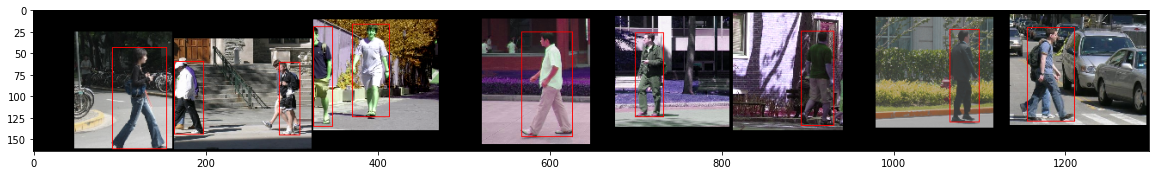

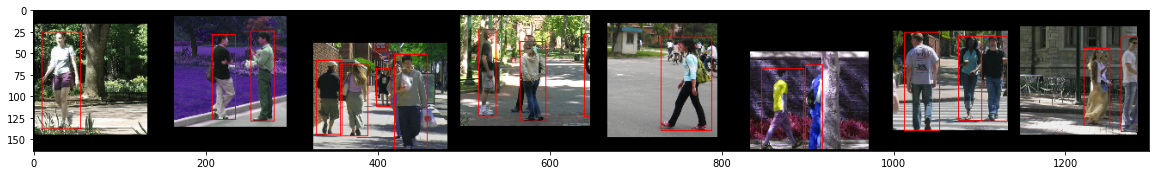

Dataset size: 100
Test:


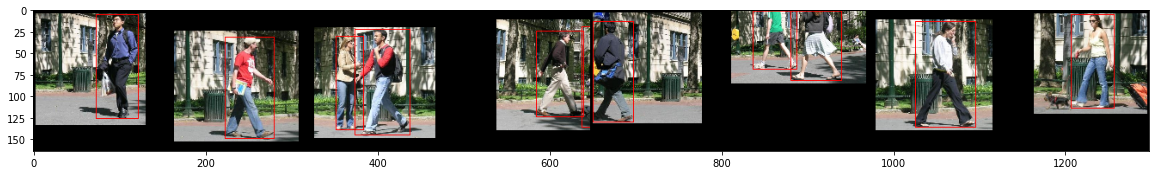

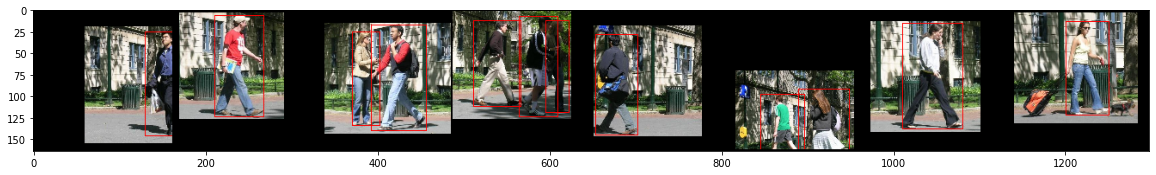

In [10]:
plt.rcParams['figure.figsize'] = [20, 20]

dataloader_train = get_dataloader(DATASET_PATH,
                                  train=True,
                                  batch_size=BATCH_SIZE_TRAIN,
                                  input_size=INPUT_SIZE
                                  )
print("Train:")
show_sample(dataloader_train, num_samples=2)


dataloader_test = get_dataloader(DATASET_PATH,
                                 train=False,
                                 batch_size=BATCH_SIZE_VALID,
                                 input_size=INPUT_SIZE
                                 )
print("Test:")
show_sample(dataloader_test, num_samples=2)

Important note: Our test data is very small. To extend our validation we also augment test dataset. We assume that our test data comes from such distribution. To avoid bad seed/randomization problems we multiply it many times (`MULTIPLY_TEST_N_TIMES` times).

# Implement Neural Network (1 p.)
For bakcbone use EfficientNet B2 pretrained on ImageNet.
* Implement missing methods.


In [11]:
import torch.nn as nn

from torchvision.models import efficientnet_b2


class Head(nn.Module):
    def __init__(self, channels_in, anchor_shapes):
        super(Head, self).__init__()
        self.channels_in = channels_in
        self.anchor_shapes = anchor_shapes
        self.cls = nn.Conv2d(channels_in, 1, kernel_size=3, padding=1)
        self.reg = nn.Conv2d(channels_in, 4, kernel_size=3, padding=1)

    def forward(self, x):
        cls = self.cls(x).view(x.shape[0], 1, x.shape[-2], x.shape[-1])
        reg = self.reg(x).view(x.shape[0], 4, x.shape[-2], x.shape[-1])
        return cls, reg


class EfficientSSD(nn.Module):
    def __init__(self, anchor_shapes):
        super(EfficientSSD, self).__init__()
        self.anchor_shapes = anchor_shapes
        features = efficientnet_b2(pretrained=True).features
        self.efficient_net1 = features[:6]
        self.efficient_net2 = features[6:]
        self.head1 = Head(120, anchor_shapes)
        self.head2 = Head(1408, anchor_shapes)
        

    def forward(self, x):
        x = self.efficient_net1(x)
        y = self.efficient_net2(x)
        res1 = self.head1(x)
        res2 = self.head2(y)
        return [res1, res2]

In [12]:
tensor = torch.ones(size=(16, 3, 160, 160))


def test_efficientnet_ssd():
    net = EfficientSSD(anchor_shapes=ANCHOR_SHAPES)
    res = net(tensor)

test_efficientnet_ssd()

# Implement generating proposals. (1 p.)
Note that at this point coordinates of boxes are in [0, 1]. Proposals size on the image should be computed using [formula for receptive field](https://www.baeldung.com/cs/cnn-receptive-field-size) or some approximation.
* Implement missing functions.

In [13]:
def generate_indexes(shape):
    # shape in (H, W) format
    (H, W) = shape
    xs, ys = [], []

    for y in range(H):
        xs.append([(x + 0.5) / W for x in range(W)])
        ys.append([(y + 0.5) / H] * W)

    xs = torch.as_tensor(xs)
    ys = torch.as_tensor(ys)

    return xs, ys


def generate_proposals(anchor_shape, output_spatial_shape):
    """
    :param anchor_shape: (H, W)
    :param output_spatial_shape: (H, W)
    :return: tensor [N, 4, H, W], coords format cxcywh all in [0, 1]
    """
    xs, ys = generate_indexes(output_spatial_shape)
    hs, ws = proposal_shape(anchor_shape, output_spatial_shape)
    res = torch.stack([xs, ys, ws, hs], dim=0)

    return res.to(device=DEVICE)


def proposal_shape(anchor_shape, output_spatial_shape):
    (H, W) = output_spatial_shape
    hs, ws = [], []
    
    for _ in range(H):
        hs.append([anchor_shape[0] / INPUT_SIZE] * W)
        ws.append([anchor_shape[1] / INPUT_SIZE] * W)

    hs = torch.as_tensor(hs)
    ws = torch.as_tensor(ws)

    return hs, ws

Lets define useful function when operating on boxes:

In [14]:
from utils import flatten_boxes_tensor

# Analyse proposals (1 p.)
* Modify previously defined ANCHOR_SIZES balancing training time and coverage of ground truth boxes. Report results.

In [88]:
# we assume our neural network makes some downsamples
num_downsamples = 4

rescale = 2**num_downsamples

boxes = []
for dp in dataloader_train:
    imgs, targets = dp
    for i in range(BATCH_SIZE_TRAIN):
        for gt_boxes in targets[i]:
            boxes.append(gt_boxes)

boxes = torch.stack(boxes).to(device=DEVICE)

dp = next(iter(dataloader_train))
imgs, targets = dp
img = imgs[0]
H_out, W_out = img.shape[1] // rescale, img.shape[2] // rescale


masks = []
for AS in ANCHOR_SHAPES:
    proposals = generate_proposals(AS, (H_out, W_out))
    proposals = flatten_boxes_tensor(proposals)
    proposals = box_convert(proposals, "cxcywh", "xyxy")

    print(f"Generating proposals: anchor shape {AS}, spatial_shape: {(H_out, W_out)} \n")

    iou_matrix = torchvision.ops.box_iou(boxes, proposals)
    debug(iou_matrix, "iou_matrix")
    iou_max, idxes = iou_matrix.max(dim=1)
    mask = iou_max > IOU_THRESHOLD
    masks.append(mask)

mask_final = reduce(torch.logical_or, masks)
print(f"In total, there is {mask_final.sum()}/{len(boxes)} gt boxes covered, that is {mask_final.sum()/len(boxes)*100:.2f} % \n")
for i, (AS, m) in enumerate(zip(ANCHOR_SHAPES, masks)):
    print(f"Anchor {AS} covers {m.sum()}/{len(boxes)}, gt boxes, that is {m.sum()/len(boxes)*100:.2f} %")
    val = reduce(torch.logical_or, masks[:i] + masks[i+1:]).sum()
    added = mask_final.sum() - val
    print(f"Adding anchor {AS} covers additional: {added}/{len(boxes)} gt boxes, that is {added / len(boxes) * 100:.2f} % \n")
    print()

Generating proposals: anchor shape (85, 40), spatial_shape: (10, 10) 

Generating proposals: anchor shape (110, 65), spatial_shape: (10, 10) 

In total, there is 270/373 gt boxes covered, that is 72.39 % 

Anchor (85, 40) covers 265/373, gt boxes, that is 71.05 %
Adding anchor (85, 40) covers additional: 167/373 gt boxes, that is 44.77 % 


Anchor (110, 65) covers 103/373, gt boxes, that is 27.61 %
Adding anchor (110, 65) covers additional: 5/373 gt boxes, that is 1.34 % 




This is copied from pytroch implementation! Before we implement loss function we define encoding and decoding functions. This encoding simplifies targets of the network to realtive offsets from corresponding proposals. In our case `encode_boxes` will be called for gt_boxes and corresponding proposals and `decode_single` will be called for output of regression and corresponding proposals. `decode_single` is modified to take `weights` as param.


In [16]:
from encode import encode_boxes, decode_single

# Implement loss function (1 p.)
This a simple (haha), iterative version of loss function. Iterates over batch and over gt_box on the image and is supposed to compute smooth l1 between gt boxes and predicted encoded boxes coordinates and cross entropy between class predictions and targets.
* Add loss functions and implement some form of balancing/sampling between positive examples and negative examples (sampling, hard negative mining, weighting loss etc.)

In [17]:
from torch.nn.functional import smooth_l1_loss, binary_cross_entropy_with_logits


def compute_loss(outputs, gt_boxes, anchor_shape, reg_weights):
    """
    :param outputs: Tuple: (cls logits tensor [N, 1, H, W] - only single class, regression output as encoded boxes tensor [N, 4, H, W]), where N is batch_size
    :param gt_boxes: format [N, 4], xyxy, xy in [0,1] x [0,1]
    :param anchor_shape: (H, W)
    :return: classification and regression losses
    """

    output_cls, output_reg = outputs

    loss_reg_init = torch.tensor(0.0, requires_grad = True).to(device=DEVICE)
    loss_cls_init = torch.tensor(0.0, requires_grad = True).to(device=DEVICE)

    loss_reg = [loss_reg_init]
    loss_cls = [loss_cls_init]

    H_out, W_out = output_reg.shape[2], output_reg.shape[3]

    # iteratively for each image in a batch
    for i in range(len(output_reg)): # assert len(output) == batch_size
        gt_boxes_per_img = gt_boxes[i]
        if len(gt_boxes_per_img) == 0:
            continue
        
        out_reg_per_img = output_reg[i]
        out_reg_per_img = flatten_boxes_tensor(out_reg_per_img)

        out_cls_per_img = output_cls[i]
        out_cls_per_img = torch.reshape(out_cls_per_img, [1, H_out*W_out]).permute([1, 0])

        proposals = generate_proposals(anchor_shape, (H_out, W_out))
        proposals = flatten_boxes_tensor(proposals)
        proposals = box_convert(proposals, "cxcywh", "xyxy")

        iou_matrix = torchvision.ops.box_iou(gt_boxes_per_img, proposals)

        if iou_matrix.numel() != 0:
            debug(iou_matrix, "iou_matrix")

        if iou_matrix.shape[0] > 0:

            # iteratively for each image in a batch # You can improve it, but not necessarily.
            for j in range(len(gt_boxes_per_img)):
                gt_box = gt_boxes_per_img[j]
                matched_to_box = iou_matrix[j] > IOU_THRESHOLD
                matched_proposals = proposals[matched_to_box, :]

                encoded = encode_boxes(gt_box.expand(matched_proposals.shape), matched_proposals, weights=reg_weights)

                out_reg = out_reg_per_img[matched_to_box]

                if out_reg.shape[0] != 0:
                    loss_reg.append(smooth_l1_loss(out_reg, encoded))

            iou_max, idxes = iou_matrix.max(dim=0)

            matched_to_any = iou_max > IOU_THRESHOLD

            neg = out_cls_per_img.clone().detach().flatten()
            neg = torch.sigmoid(neg)
            neg[matched_to_any] = 0  # only negatives are non zero
            neg[neg < CLS_THRESHOLD] = 0  # exclude light negatives
            hard_negative = (neg > 0).reshape(matched_to_any.shape) # now all non zero elements are hard negatives

            mask_cls = torch.logical_or(matched_to_any, hard_negative)

            if matched_to_any.count_nonzero():

                out_cls_ = torch.squeeze(out_cls_per_img).float()[mask_cls]
                targets_cls_ = matched_to_any.float()[mask_cls]

                POS_WEIGHT = torch.Tensor([0.25])
                loss_cls_ = binary_cross_entropy_with_logits(out_cls_, targets_cls_)
                loss_cls.append(loss_cls_)

    loss_cls = torch.stack(loss_cls).sum()
    loss_reg = torch.stack(loss_reg).sum()
    return loss_cls, loss_reg

# Lightning model definition - implement predict_step (1 p.)
As metric we use Mean Average Precission, see [mAP](https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2) and [mAP](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173). In postprocess we remove small boxes and we remove overlapping boxes with lower scores (non maximum suppression).

In [90]:
import pytorch_lightning as pt
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics.detection import MeanAveragePrecision


class SimpleModel(pt.LightningModule):
    def __init__(self, net):
        super().__init__()
        self._net = net
        self._map = MeanAveragePrecision().cpu()
        self._reg_weights = torch.from_numpy(np.array([1, 1, 1, 1])).to(device=DEVICE)

    def forward(self, x):
        return self._net(x)

    def on_epoch_start(self):
        self.log("lr", self.lr_schedulers().get_last_lr()[0])

    def on_epoch_end(self):
        self.lr_schedulers().step()

    def training_step(self, batch, batch_idx):
        imgs, gt_boxes = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        loss_cls, loss_reg = compute_loss(outputs[0], gt_boxes, self._net.anchor_shapes[0], self._reg_weights)
        loss_cls2, loss_reg2 = compute_loss(outputs[1], gt_boxes, self._net.anchor_shapes[1], self._reg_weights)

        loss_cls += loss_cls2
        loss_reg += loss_reg2

        l_reg = COEFF_REG * loss_reg
        l_cls = COEFF_CLS * loss_cls
        loss = l_cls + l_reg
        self.log("reg_loss", l_reg)
        self.log("cls_loss", l_cls)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return [optimizer], [ExponentialLR(optimizer, gamma=LR_DECAY)]

    def on_validation_epoch_start(self):
      self._map.cpu()
      self._map.reset()

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        self._map.cpu()
        
        res_imgs = []
        for i in range(len(imgs)):
            im = imgs[i]
            out_cls = outputs[0][0][i]
            out_reg = outputs[0][1][i]
            gt_boxes = targets[i]

            im = denormalize(im).byte()

            proposals = generate_proposals(self._net.anchor_shapes[0], (out_cls.shape[1], out_cls.shape[2]))

            scores, boxes = self.postprocess(out_cls, out_reg, cls_threshold=CLS_THRESHOLD, proposals=proposals)

            idxes = torchvision.ops.nms(boxes, scores, iou_threshold=NMS_THRESHOLD)
            boxes = boxes[idxes]
            scores = scores[idxes]

            H, W = im.shape[1], im.shape[2]

            if boxes.shape[0] > 0:
                boxes = denormalize_boxes(boxes, H, W)
            gt_bb = denormalize_boxes(gt_boxes, H, W)

            if batch_idx < VAL_IMGS_TO_SEND:
                im = draw_bounding_boxes(im.cpu(), gt_bb.cpu(), colors=(255, 0, 0))
                im = draw_bounding_boxes(im, boxes.cpu(), colors=(0, 255, 0))
                res_imgs.append(im)

            labels = torch.ones(scores.shape, dtype=torch.int32)
            labels2 = torch.ones(gt_boxes.shape[0], dtype=torch.int32)

            preds = [{"boxes": boxes.cpu(), "scores": scores.cpu(), "labels": labels.cpu()}]
            target = [{"boxes": gt_bb.cpu(), "labels": labels2.cpu()}]
            self._map.update(preds, target)
        
        if batch_idx < VAL_IMGS_TO_SEND:
            res_imgs = torch.stack(res_imgs, dim=0)

            res_grid = torchvision.utils.make_grid(res_imgs)
            self.logger.experiment.add_image(f'outputs{batch_idx}', res_grid, global_step=self.global_step)

        self.log('val_map', self._map.compute()['map'])

    def on_validation_epoch_end(self):
        self.log('val_map', self._map.compute()['map'])

    def predict_step(self, batch, batch_idx):
        """
        :return: list of length M, where M is number of images, 
            which for each image contains list of boxes in format xyxy, xy in [0, W]x[0, H]
        """
        imgs, targets = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        self._map.cpu()
        
        res_boxes, res_imgs = [], []
        for i in range(len(imgs)):
            im = imgs[i]
            out_cls = outputs[0][0][i]
            out_reg = outputs[0][1][i]
            gt_boxes = targets[i]

            im = denormalize(im).byte()

            proposals = generate_proposals(self._net.anchor_shapes[0], (out_cls.shape[1], out_cls.shape[2]))

            scores, boxes = self.postprocess(out_cls, out_reg, cls_threshold=CLS_THRESHOLD, proposals=proposals)

            idxes = torchvision.ops.nms(boxes, scores, iou_threshold=NMS_THRESHOLD)
            boxes = boxes[idxes]
            scores = scores[idxes]

            H, W = im.shape[1], im.shape[2]

            if boxes.shape[0] > 0:
                boxes = denormalize_boxes(boxes, H, W)
            gt_bb = denormalize_boxes(gt_boxes, H, W)
            res_boxes.append(boxes)

            if batch_idx < VAL_IMGS_TO_SEND:
                im = draw_bounding_boxes(im.cpu(), gt_bb.cpu(), colors=(255, 0, 0))
                im = draw_bounding_boxes(im, boxes.cpu(), colors=(0, 255, 0))
                res_imgs.append(im)
        
                if i == len(imgs) - 1:
                    res_grid = torch.stack(res_imgs, dim=0)
                    res_grid = torchvision.utils.make_grid(res_imgs)
                    res_grid = res_grid.permute([1, 2, 0])
                    plt.imshow(res_grid / 255)
                    plt.show()

            # Uncomment below code to calculate map and print precision
            # labels = torch.ones(scores.shape, dtype=torch.int32)
            # labels2 = torch.ones(gt_boxes.shape[0], dtype=torch.int32)

            # preds = [{"boxes": boxes.cpu(), "scores": scores.cpu(), "labels": labels.cpu()}]
            # target = [{"boxes": gt_bb.cpu(), "labels": labels2.cpu()}]
            # self._map.update(preds, target)
        
        # Print results because pytorch lighting doesnt allow for logging in predict_step
        # print(f"Prediction precision: {self._map.compute()['map']}")

        return res_boxes

    def postprocess(self, out_cls, out_reg, cls_threshold, proposals):
        """
        out_reg -> "cxcywh"
        """
        scores = torch.sigmoid(out_cls)
        mask = scores >= cls_threshold

        proposals_boxes_ = proposals.expand(out_reg.shape)
        proposals_boxes_ = proposals_boxes_[:, mask.squeeze()]
        proposals_boxes_ = flatten_boxes_tensor(proposals_boxes_)

        out_reg = out_reg[mask.expand(out_reg.shape)]
        out_reg = flatten_boxes_tensor(out_reg)
        out_reg = decode_single(out_reg, proposals_boxes_, weights=self._reg_weights)

        scores = scores[mask]

        out_reg = torchvision.ops.clip_boxes_to_image(out_reg, (1, 1))
        idxes = torchvision.ops.remove_small_boxes(out_reg, min_size=1 / 100)

        out_reg = out_reg[idxes]
        scores = scores[idxes]

        return scores, out_reg

# Training and validation (2 p.)
You should achive > 55 mAP. After 2k steps results should start looking reasonable. On gpu it should run ~1Epoch/10s, so after ~15 minutes you should see some reasonable detections.
* Modify training paramters, optimizer, etc. and use other ML techniques of your choice (regularization, test time augmentation etc.).

In [93]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [95]:
%tensorboard --logdir tb_logs # --host localhost --port 8088

In [96]:
from pytorch_lightning.loggers import TensorBoardLogger


logger = TensorBoardLogger("tb_logs", name="my_model")

net = EfficientSSD(anchor_shapes=ANCHOR_SHAPES)
model = SimpleModel(net)

trainer = pt.Trainer(max_epochs=EPOCHS,
                     detect_anomaly=DETECT_ANOMALY,
                     logger=logger,
                     check_val_every_n_epoch=10,
                     accelerator=ACCELEREATOR,
                     fast_dev_run=FAST_DEV_RUN,
                     profiler='simple',
                     devices=1
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dataloader_train, dataloader_test)
trainer.save_checkpoint("simple_ssd.ckpt")

In [ ]:
trainer.save_checkpoint("simple_ssd.ckpt")

In [ ]:
!ls tb_logs

my_model


In [ ]:
# !rm -r tb_logs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

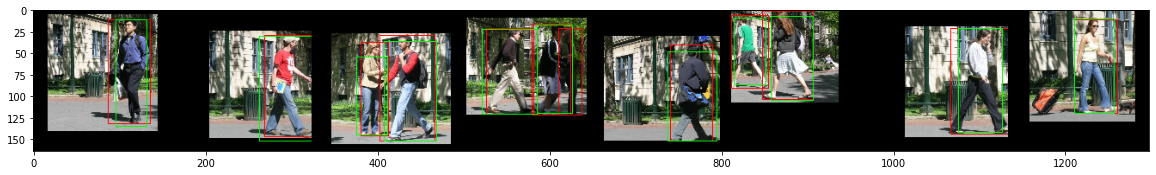

Prediction precision: 0.5635635852813721


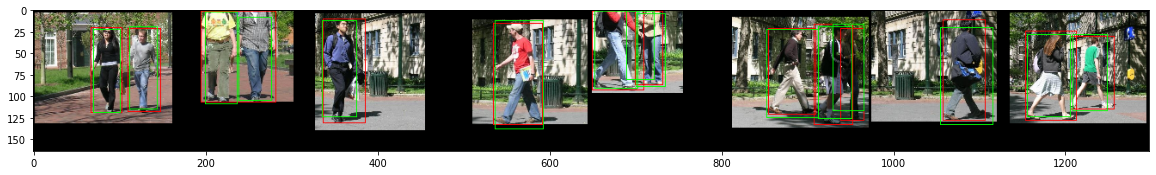

Prediction precision: 0.5667695999145508
Prediction precision: 0.5698723196983337
Prediction precision: 0.5717910528182983
Prediction precision: 0.5756016969680786
Prediction precision: 0.5746529698371887
Prediction precision: 0.5673449635505676
Prediction precision: 0.5655012726783752
Prediction precision: 0.566874623298645
Prediction precision: 0.5692936778068542
Prediction precision: 0.5686913132667542
Prediction precision: 0.5723943710327148


PREDICT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  22.026         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------------
predict_step                       	|  0.56717        	|26             	|  14.746         	|  66.951         	|
on_predict_epoch_start             	|  0.017675       	|2              	|  0.03535        	|  0.16049        	|
predict_batch_to_device            	|  0.0012104      	|26             	|  0.03147        	|  0.14288        	|
on_predict_batch_end               	|  0.00089405     	|26             	|  0.023245       	|  0.10554        	|
on_predict_end         

Prediction precision: 0.5740733742713928


In [98]:
checkpoint = torch.load("simple_ssd.ckpt")

model.load_state_dict(checkpoint["state_dict"])

res_boxes = trainer.predict(model=model, dataloaders=[dataloader_test])
res_boxes = list(chain(*res_boxes))
assert len(res_boxes) == len(dataloader_test.dataset)

# Extend implementation to multiple ANCHORS (1 p.) and multiple output scales (1 p.)
It's ok if it's not completely general, but it has to be at more scales and/or using more anchors.

In [ ]:
ANCHOR_SHAPES = [(25, 10), (60, 35), (80, 25), (85, 40), (110, 65)]

Head generalized for more anchores  
SSD generalized for more heads and more anchors

In [ ]:
class HeadGeneralized(nn.Module):
    def __init__(self, channels_in, anchor_shapes):
        super(HeadGeneralized, self).__init__()
        self.channels_in = channels_in
        self.anchor_shapes = anchor_shapes
        self.cls = nn.Conv2d(channels_in, len(anchor_shapes), kernel_size=3, padding=1)
        self.reg = nn.Conv2d(channels_in, 4 * len(anchor_shapes), kernel_size=3, padding=1)

    def forward(self, x):
        cls = self.cls(x).view(x.shape[0], len(self.anchor_shapes), x.shape[-2], x.shape[-1])
        reg = self.reg(x).view(x.shape[0], 4 * len(self.anchor_shapes), x.shape[-2], x.shape[-1])
        cls = [cls[:, i:i+1, :, :] for i in range(len(self.anchor_shapes))]
        reg = [reg[:, 4*i:4*(i+1), :, :] for i in range(len(self.anchor_shapes))]
        return cls, reg


class EfficientSSDGeneralized(nn.Module):
    def __init__(self, anchor_shapes):
        super(EfficientSSDGeneralized, self).__init__()
        self.anchor_shapes = anchor_shapes
        features = efficientnet_b2(pretrained=True).features
        self.layers = nn.ModuleList([
                features[:2], 
                features[2:3], 
                features[3:4], 
                features[:6], 
                features[6:]
            ])
        self.heads = nn.ModuleList([
                HeadGeneralized(16, anchor_shapes), 
                HeadGeneralized(24, anchor_shapes), 
                HeadGeneralized(48, anchor_shapes), 
                HeadGeneralized(120, anchor_shapes), 
                HeadGeneralized(1408, anchor_shapes)
            ])

    def forward(self, x):
        ret = []
        for layer, head in zip(self.layers, self.heads):
            x = layer(x)
            cls, reg = head(x)
            ret.append(list(zip(cls, reg)))

        return ret

### Loss computation and model generalized for more anchores and heads.

In [ ]:
def compute_loss_generalized(outputs, gt_boxes, anchor_shape, reg_weights):
    """
    :param outputs: Tuple: (cls logits tensor [N, 1, H, W] - only single class, regression output as encoded boxes tensor [N, 4, H, W]), where N is batch_size
    :param gt_boxes: format [N, 4], xyxy, xy in [0,1] x [0,1]
    :param anchor_shape: (H, W)
    :return: classification and regression losses
    """

    output_cls, output_reg = outputs

    loss_reg_init = torch.tensor(0.0, requires_grad = True).to(device=DEVICE)
    loss_cls_init = torch.tensor(0.0, requires_grad = True).to(device=DEVICE)

    loss_reg = [loss_reg_init]
    loss_cls = [loss_cls_init]

    H_out, W_out = output_reg.shape[2], output_reg.shape[3]

    # iteratively for each image in a batch
    for i in range(len(output_reg)): # assert len(output) == batch_size
        gt_boxes_per_img = gt_boxes[i]
        if len(gt_boxes_per_img) == 0:
            continue
        
        out_reg_per_img = output_reg[i]
        out_reg_per_img = flatten_boxes_tensor(out_reg_per_img)

        out_cls_per_img = output_cls[i]
        out_cls_per_img = torch.reshape(out_cls_per_img, [1, H_out*W_out]).permute([1, 0])

        proposals = generate_proposals(anchor_shape, (H_out, W_out))
        proposals = flatten_boxes_tensor(proposals)
        proposals = box_convert(proposals, "cxcywh", "xyxy")

        iou_matrix = torchvision.ops.box_iou(gt_boxes_per_img, proposals)

        if iou_matrix.numel() != 0:
            debug(iou_matrix, "iou_matrix")

        if iou_matrix.shape[0] > 0:

            # iteratively for each image in a batch # You can improve it, but not necessarily.
            for j in range(len(gt_boxes_per_img)):
                gt_box = gt_boxes_per_img[j]
                matched_to_box = iou_matrix[j] > IOU_THRESHOLD
                matched_proposals = proposals[matched_to_box, :]

                encoded = encode_boxes(gt_box.expand(matched_proposals.shape), matched_proposals, weights=reg_weights)

                out_reg = out_reg_per_img[matched_to_box]

                if out_reg.shape[0] != 0:
                    loss_reg.append(smooth_l1_loss(out_reg, encoded))

            iou_max, idxes = iou_matrix.max(dim=0)

            matched_to_any = iou_max > IOU_THRESHOLD

            neg = out_cls_per_img.clone().detach().flatten()
            neg = torch.sigmoid(neg)
            neg[matched_to_any] = 0  # only negatives are non zero
            neg[neg < CLS_THRESHOLD] = 0  # exclude light negatives
            hard_negative = (neg > 0).reshape(matched_to_any.shape) # now all non zero elements are hard negatives

            mask_cls = torch.logical_or(matched_to_any, hard_negative)

            if matched_to_any.count_nonzero():

                out_cls_ = torch.squeeze(out_cls_per_img).float()[mask_cls]
                targets_cls_ = matched_to_any.float()[mask_cls]

                POS_WEIGHT = 1 # TODO You can use weighting
                loss_cls_ = binary_cross_entropy_with_logits(out_cls_, targets_cls_)
                loss_cls.append(loss_cls_)

    loss_cls = torch.stack(loss_cls).sum()
    loss_reg = torch.stack(loss_reg).sum()
    return loss_cls, loss_reg

In [ ]:
class GeneralizedModel(pt.LightningModule):
    def __init__(self, net):
        super().__init__()
        self._net = net
        self._map = MeanAveragePrecision().cpu()
        self._reg_weights = torch.from_numpy(np.array([1, 1, 1, 1])).to(device=DEVICE)

    def forward(self, x):
        return self._net(x)

    def on_epoch_start(self):
        self.log("lr", self.lr_schedulers().get_last_lr()[0])

    def on_epoch_end(self):
        self.lr_schedulers().step()

    def training_step(self, batch, batch_idx):
        imgs, gt_boxes = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        loss_cls, loss_reg = 0.0, 0.0

        for shape, out_for_anchor in zip(self._net.anchor_shapes, outputs):
            for output in out_for_anchor:
                loss_cls_, loss_reg_ = compute_loss_generalized(output, gt_boxes, shape, self._reg_weights)
                loss_cls += loss_cls_
                loss_reg += loss_reg_

        l_reg = COEFF_REG * loss_reg
        l_cls = COEFF_CLS * loss_cls
        loss = l_cls + l_reg
        self.log("reg_loss", l_reg)
        self.log("cls_loss", l_cls)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        return [optimizer], [ExponentialLR(optimizer, gamma=LR_DECAY)]

    def on_validation_epoch_start(self):
        self._map.cpu()
        self._map.reset()

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        self._map.cpu()

        res_imgs = []
        for i in range(len(imgs)):
            im = imgs[i]
            gt_boxes = targets[i]
            im = denormalize(im).byte()
            
            boxes, scores = [], []
            for shape, out_for_anchor in zip(self._net.anchor_shapes, outputs):
                for output in out_for_anchor:
                    out_cls = output[0][i]
                    out_reg = output[1][i]

                    proposals = generate_proposals(shape, (out_cls.shape[1], out_cls.shape[2]))

                    scores_, boxes_ = self.postprocess(out_cls, out_reg, cls_threshold=CLS_THRESHOLD, proposals=proposals)
                    
                    boxes.append(boxes_)
                    scores.append(scores_)
            
            boxes = torch.cat(boxes)
            scores = torch.cat(scores)

            idxes = torchvision.ops.nms(boxes, scores, iou_threshold=NMS_THRESHOLD)
            boxes = boxes[idxes]
            scores = scores[idxes]

            H, W = im.shape[1], im.shape[2]

            if boxes.shape[0] > 0:
                boxes = denormalize_boxes(boxes, H, W)
            gt_bb = denormalize_boxes(gt_boxes, H, W)

            if batch_idx < VAL_IMGS_TO_SEND:
                im = draw_bounding_boxes(im.cpu(), gt_bb.cpu(), colors=(255, 0, 0))
                im = draw_bounding_boxes(im, boxes.cpu(), colors=(0, 255, 0))
                res_imgs.append(im)

            labels = torch.ones(scores.shape, dtype=torch.int32)
            labels2 = torch.ones(gt_boxes.shape[0], dtype=torch.int32)

            preds = [{"boxes": boxes.cpu(), "scores": scores.cpu(), "labels": labels.cpu()}]
            target = [{"boxes": gt_bb.cpu(), "labels": labels2.cpu()}]
            self._map.update(preds, target)
        
        if batch_idx < VAL_IMGS_TO_SEND:
            res_imgs = torch.stack(res_imgs, dim=0)

            res_grid = torchvision.utils.make_grid(res_imgs)
            self.logger.experiment.add_image(f'outputs{batch_idx}', res_grid, global_step=self.global_step)

        self.log('val_map', self._map.compute()['map'])

    def on_validation_epoch_end(self):
        self.log('val_map', self._map.compute()['map'])

    
    def predict_step(self, batch, batch_idx):
        imgs, targets = batch

        imgs = torch.stack(imgs, dim=0)

        outputs = self(imgs)

        self._map.cpu()
        
        res_boxes, res_imgs = [], []
        for i in range(len(imgs)):
            im = imgs[i]
            out_cls = outputs[0][0][i]
            out_reg = outputs[0][1][i]
            gt_boxes = targets[i]

            im = denormalize(im).byte()

            proposals = generate_proposals(self._net.anchor_shapes[0], (out_cls.shape[1], out_cls.shape[2]))

            scores, boxes = self.postprocess(out_cls, out_reg, cls_threshold=CLS_THRESHOLD, proposals=proposals)

            idxes = torchvision.ops.nms(boxes, scores, iou_threshold=NMS_THRESHOLD)
            boxes = boxes[idxes]
            scores = scores[idxes]

            H, W = im.shape[1], im.shape[2]

            if boxes.shape[0] > 0:
                boxes = denormalize_boxes(boxes, H, W)
            gt_bb = denormalize_boxes(gt_boxes, H, W)
            res_boxes.append(boxes)

            if batch_idx < VAL_IMGS_TO_SEND:
                im = draw_bounding_boxes(im.cpu(), gt_bb.cpu(), colors=(255, 0, 0))
                im = draw_bounding_boxes(im, boxes.cpu(), colors=(0, 255, 0))
                res_imgs.append(im)
        
                if i == len(imgs) - 1:
                    res_grid = torch.stack(res_imgs, dim=0)
                    res_grid = torchvision.utils.make_grid(res_imgs)
                    res_grid = res_grid.permute([1, 2, 0])
                    plt.imshow(res_grid / 255)
                    plt.show()

        return res_boxes

    def postprocess(self, out_cls, out_reg, cls_threshold, proposals):
        """
        out_reg -> "cxcywh"
        """
        scores = torch.sigmoid(out_cls)
        mask = scores >= cls_threshold

        proposals_boxes_ = proposals.expand(out_reg.shape)
        proposals_boxes_ = proposals_boxes_[:, mask.squeeze()]
        proposals_boxes_ = flatten_boxes_tensor(proposals_boxes_)

        out_reg = out_reg[mask.expand(out_reg.shape)]
        out_reg = flatten_boxes_tensor(out_reg)
        out_reg = decode_single(out_reg, proposals_boxes_, weights=self._reg_weights)

        scores = scores[mask]

        out_reg = torchvision.ops.clip_boxes_to_image(out_reg, (1, 1))
        idxes = torchvision.ops.remove_small_boxes(out_reg, min_size=1 / 100)

        out_reg = out_reg[idxes]
        scores = scores[idxes]

        return scores, out_reg

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs --host localhost --port 8088

In [ ]:
logger = TensorBoardLogger("tb_logs", name="my_model")

net = EfficientSSDGeneralized(anchor_shapes=ANCHOR_SHAPES)
model = GeneralizedModel(net)

trainer = pt.Trainer(max_epochs=EPOCHS,
                     detect_anomaly=DETECT_ANOMALY,
                     logger=logger,
                     check_val_every_n_epoch=10,
                     accelerator=ACCELEREATOR,
                     fast_dev_run=FAST_DEV_RUN,
                     profiler='simple',
                     devices=1
                     )

trainer.fit(model, dataloader_train, dataloader_test)
trainer.save_checkpoint("simple_ssd.ckpt")

## Report

#### Architecture
Quiet surprisingly, generalized model with many heads and many anchors seems to work much worse than simple model with 2 anchors and 2 heads (only one of them used for validation).
Additional outputs seem to add huge, unnecessary noise, making training way harder.
I tried using many combinations of heads, outputing feature maps of different sizes but in the end pair of feature maps ((10x10), 120 channels; (5x5), 1408 channels) seemed to work the best. However, it was important to use first output (120) for mean precision calculation because second one was giving worse results.


#### Anchors
We achieve most picture coverage when using anchors of ratio between 3:1 and 2:1. 
Also most of the times people are taking big part of the photo so best anchors are those with height around half of the picture - around 80 pixels. That's the reason why I chose anchors (85, 40), (110, 65).


#### Hyperparameters
After extensive testing and using many different values I decided to change only one parameter - lr_decay from 0.997 to 0.998. Other parameters worked just fine as they were set initially.


#### Logs
Alongside my solution I also provided folder with logs from training of the best model because I don't think it's possible to put tensorboard logs directly in the notebook.